# Analysis

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib_venn import venn2, venn3

In [2]:
sns.set_style("darkgrid")

In [244]:
input_csv = "../data/plos2016.csv"
urls_csv = "../data/urls.csv"
query_csv = "../data/queries.csv"
og_csv = "../data/og_objects.csv"
altmetric_csv = "../data/altmetric.csv"

In [245]:
articles = pd.read_csv(input_csv, index_col="doi", parse_dates=['publication_date'])
urls = pd.read_csv(urls_csv, index_col="url_id", parse_dates=['added_on'])
queries = pd.read_csv(query_csv, index_col="query_id", parse_dates=['queried_at'])
og_objects = pd.read_csv(og_csv, index_col="og_id", parse_dates=['og_updated_time', 'received_at'])

In [246]:
def extract_shares(x):
    try:
        s = json.loads(x)['counts']['facebook']['posts_count']
    except:
        s = None
    return s

am = pd.read_csv(altmetric_csv, index_col="doi")
am['shares'] = am['am_resp'].map(extract_shares)

In [247]:
num_cols = ['reactions', 'shares', 'comments', 'plugin_comments']
og_objects[num_cols] = og_objects[num_cols].astype(int)

In [248]:
a = og_objects.merge(queries, left_on="query_id", right_index=True, how="left")

In [249]:
b = a.merge(urls, left_on="url_id", right_index=True, how="left")

In [250]:
c = b.merge(articles, left_on="doi", right_index=True, how="left")

## Statistics about link distribution and sharing

In [251]:
# Link types that were shared once at least
c.groupby("type").size()

type
authors       102
comments       24
doi           224
doi_old      1730
landing     12953
metrics      1213
pdf           667
related        33
dtype: int64

In [253]:
diff_ogids = c.reset_index().groupby(["doi", "og_id"]).size().groupby(['doi']).count()
diff_ogids.value_counts()

1    12369
2      637
3        4
4        1
dtype: int64

In [254]:
diff_links = c.reset_index().groupby(["doi"])['og_id'].size()
diff_links.value_counts()

1    9653
2    2888
3     389
4      66
5       9
7       3
6       2
8       1
Name: og_id, dtype: int64

## Remove duplicate OpenGraph objects

In [255]:
fb_shares = c.reset_index().groupby(["doi", "og_id"]).first().groupby(["doi"]).sum()['shares']
am_shares = am['shares'].dropna()

fb_shares.name = "fb0"
am_shares.name = "am"
# fb_shares = fb_shares[fb_shares>0]

In [256]:
s = pd.concat([fb_shares, am_shares], axis=1)
s['fb'] = s.fb0.replace(0, np.nan)
s['diff'] = s.fb - s.am
s.head()

/home/asura/.virtualenvs/altmetrics/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,fb0,am,fb,diff
10.1371/journal.pone.0083032,9.0,NaN,9.0,NaN
10.1371/journal.pone.0103617,0.0,NaN,NaN,NaN
10.1371/journal.pone.0109913,0.0,NaN,NaN,NaN
10.1371/journal.pone.0117805,0.0,NaN,NaN,NaN
10.1371/journal.pone.0127505,3.0,NaN,3.0,NaN


In [257]:
# Remove outliers beyond Q3+1.5*IQR
Q1 = s['diff'].quantile(0.25)
Q3 = s['diff'].quantile(0.75)
IQR = Q3 - Q1
y_max = Q3 + 1.5 * IQR

s['diff-no-outlier'] = s['diff'].where(s['diff'] <= y_max, np.nan)

In [258]:
s.describe()

,fb0,am,fb,diff,diff-no-outlier
count,13011.000000,3202.000000,5635.000000,1958.000000,1720.000000
mean,3.294827,2.332605,7.607631,14.827375,2.745349
std,47.791389,4.266826,72.397668,119.667790,4.234025
min,0.000000,1.000000,1.000000,-24.000000,-24.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,2.000000,2.000000,1.000000
75%,1.000000,2.000000,4.000000,7.000000,4.000000
max,4181.000000,79.000000,4181.000000,4157.000000,17.000000


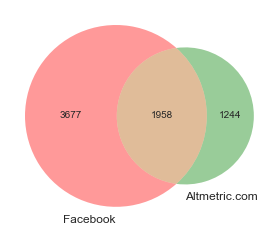

In [259]:
am_set = set(s[s.am.notnull()].index.tolist())
fb_set = set(s[s.fb.notnull()].index.tolist())
fb0_set = set(s[s.fb0.notnull()].index.tolist())

venn2([fb_set, am_set], set_labels = ('Facebook', 'Altmetric.com'));

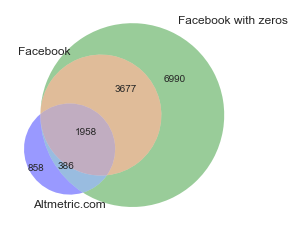

In [260]:
venn3([fb_set, fb0_set, am_set], set_labels = ('Facebook', 'Facebook with zeros', 'Altmetric.com'));

In [153]:
# diff = s['diff']
diff = s['diff-no-outlier'].dropna()

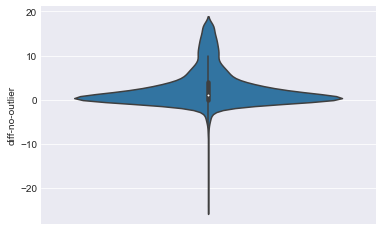

In [154]:
sns.violinplot(y=diff)

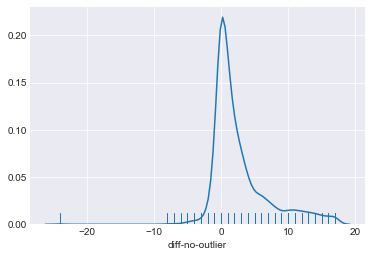

In [155]:
sns.distplot(diff, hist=False, rug=True, norm_hist=True);

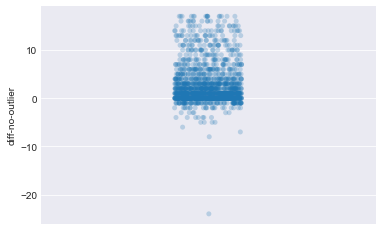

In [201]:
sns.stripplot(y=diff, jitter=True, alpha=.25,)

In [172]:
pdf = s.melt(value_vars=["fb","am"], var_name="source")

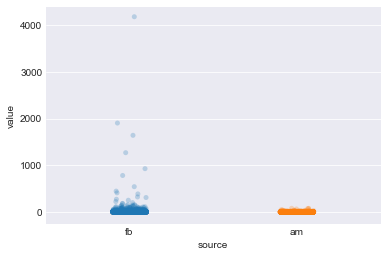

In [200]:
sns.stripplot(x="source", y="value", data=pdf, jitter=True, alpha=.25)

## Others

In [156]:
a = c.reset_index().groupby(["type", "og_id"]).mean().groupby(["type"]).mean()
a['size'] = c.reset_index().groupby(["type", "og_id"]).mean().groupby(["type"]).size()
a

,query_id,reactions,shares,comments,plugin_comments,url_id,error_msg,size
type,,,,,,,,
authors,70421.103093,239.391753,91.773196,167.092784,0.0,75507.639175,NaN,97
comments,76147.086957,1012.347826,429.826087,791.217391,0.0,83162.565217,NaN,23
doi,68643.444444,116.463768,47.859903,83.835749,0.0,72652.512077,NaN,207
doi_old,66678.180428,61.319266,17.390214,24.418349,0.0,69801.735168,NaN,1635
landing,62171.909592,12.703641,3.185519,4.375172,0.0,64364.476445,NaN,12333
metrics,68334.552682,25.822797,8.480843,15.883142,0.0,70388.348659,NaN,1044
pdf,68285.620690,0.752351,0.341693,0.363636,0.0,71217.231975,NaN,638
related,72035.812500,494.406250,204.593750,223.000000,0.0,76503.250000,NaN,32
